# 1. 데이터: MNIST
- 숫자 분류 이미지 데이터 셋인 MNIST 이미지 데이터 셋을 활용함

![image.png](https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/MnistExamples.png/480px-MnistExamples.png)

In [204]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [205]:
print("Train Shape:",x_train.shape)
print("Test Shape:",x_test.shape)

Train Shape: (60000, 28, 28, 1)
Test Shape: (10000, 28, 28, 1)


# 2. CNN Auto Encoder 모델 학습
- CNN Auto Encoder 모델을 활용하여 이미지를 재구축하도록 학습을 진행함
- 학습된 CNN AE 모델을 통해 각 이미지에 대한 Latent Vector를 추출할 수 있음

![image.png](https://ifh.cc/g/kbWawd.jpg)

In [206]:
# 필요 라이브러리 load
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='root_mean_squared_error')

In [209]:
encoder = keras.Model(input_img, encoded)

In [210]:
# model compile
autoencoder.compile(optimizer='adam',
              loss='binary_crossentropy')

## train
history = autoencoder.fit(x_train, x_train,
                epochs=5, #20
                batch_size=512,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/5
118/118 [==============================] - 17s 140ms/step - loss: 0.2596 - val_loss: 0.1834
Epoch 2/5
118/118 [==============================] - 17s 141ms/step - loss: 0.1637 - val_loss: 0.1499
Epoch 3/5
118/118 [==============================] - 17s 143ms/step - loss: 0.1433 - val_loss: 0.1361
Epoch 4/5
118/118 [==============================] - 17s 143ms/step - loss: 0.1326 - val_loss: 0.1275
Epoch 5/5
118/118 [==============================] - 17s 144ms/step - loss: 0.1256 - val_loss: 0.1219


# 3. CNN Auto Encoder Latent Vector 시각화
- CNN Auto Encoder 모델의 Latent Vector를 활용하여 시각화를 진행함
- 시각화 기법인 PCA와 t-SNE를 활용함

In [211]:
encoded_imgs = encoder.predict(x_train)
encoded_imgs.shape

1875/1875 [==============================] - 4s 2ms/step


(60000, 4, 4, 8)

In [212]:
sample_idx = np.random.choice(encoded_imgs.shape[0],1000)
encoded_imgs = encoded_imgs[sample_idx]
encoded_imgs.shape

(1000, 4, 4, 8)

In [213]:
encoded_imgs_flatten = encoded_imgs.reshape(1000,-1)

In [214]:
print('축소된 이미지의 representation : {}\n'.format(encoded_imgs_flatten.shape))

축소된 이미지의 representation : (1000, 128)



In [215]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
encoded_imgs_flatten = scaler.fit_transform(encoded_imgs_flatten)

### Step 1. PCA를 활용한 시각화

In [216]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(encoded_imgs_flatten.T)

print('singular value :', pca.singular_values_)
print('singular vector :\n', pca.components_.T)

latent_vector = pca.components_.T

singular value : [140.1575  128.31044]
singular vector :
 [[-0.03600899 -0.02899842]
 [-0.02583345 -0.0094324 ]
 [ 0.03971349 -0.05775934]
 ...
 [-0.01719852  0.03934282]
 [-0.01596932  0.0148509 ]
 [ 0.0550312   0.02485452]]


In [217]:
latent_vector.shape

(1000, 2)

In [218]:
latent_vector

array([[-0.03600899, -0.02899842],
       [-0.02583345, -0.0094324 ],
       [ 0.03971349, -0.05775934],
       ...,
       [-0.01719852,  0.03934282],
       [-0.01596932,  0.0148509 ],
       [ 0.0550312 ,  0.02485452]], dtype=float32)

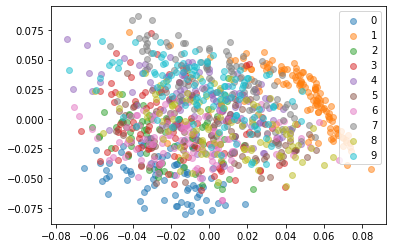

In [219]:
import matplotlib.pyplot as plt
y_train2 = y_train[sample_idx]

for cls in set(y_train) :
    idx = np.where(y_train2==cls)[0]
    #sample_idx = np.random.choice(idx,100)
    plt.scatter(latent_vector[idx,0],latent_vector[idx,1],label='{}'.format(cls),alpha=0.5)
plt.legend()

### Step 2. t-SNE를 활용한 시각화

In [220]:
from sklearn.manifold import TSNE
# t-SNE 모델 생성 및 학습
tsne = TSNE(random_state=0)

digits_tsne = tsne.fit_transform(encoded_imgs_flatten)

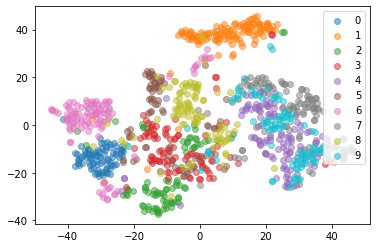

In [221]:
for cls in set(y_train) :
    idx = np.where(y_train2==cls)[0]
    plt.scatter(digits_tsne[idx,0],digits_tsne[idx,1],label='{}'.format(cls),alpha=0.5)
plt.legend()

# 4. 군집화 알고리즘 적용 및 군집 타당성 평가
- 군집화 알고리즘인 K-means 기법과 DBSCAN 방법론을 적용하여 Latent Vector에 대한 군집화를 진행함
- 각 알고리즘에 대하여 군집 타당성을 평가함

- 1번 지표 값은 크고, 2, 3번 지표 값은 작을수록 좋은 군집화 평가를 받음
![image.png](https://ifh.cc/g/gZ60TC.jpg)

### Step 1. K Means & DBSCAN 군집화 알고리즘

In [222]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=10, random_state=0)
model.fit(encoded_imgs_flatten) ##encoded_img 128차원의 latent vector 넣어서 클러스터링함
y_pred_kmeans = model.labels_

In [223]:
y_pred_kmeans

array([5, 3, 8, 8, 6, 2, 2, 8, 8, 6, 0, 5, 6, 0, 6, 3, 2, 5, 8, 9, 8, 5,
       4, 7, 1, 2, 2, 7, 2, 2, 6, 8, 0, 4, 1, 5, 4, 7, 3, 0, 7, 2, 1, 8,
       1, 9, 4, 9, 4, 9, 3, 8, 1, 8, 1, 6, 2, 8, 3, 2, 7, 1, 3, 8, 3, 4,
       8, 8, 7, 2, 2, 4, 1, 2, 4, 8, 7, 4, 5, 4, 8, 2, 5, 7, 5, 3, 8, 8,
       7, 2, 6, 3, 7, 2, 4, 4, 4, 9, 4, 3, 9, 6, 7, 3, 2, 4, 8, 2, 7, 4,
       5, 4, 5, 7, 2, 0, 7, 4, 3, 6, 3, 9, 8, 1, 5, 7, 7, 9, 9, 2, 7, 5,
       4, 3, 9, 4, 5, 1, 2, 9, 0, 4, 5, 0, 6, 3, 5, 0, 2, 3, 9, 5, 6, 4,
       1, 4, 2, 8, 3, 4, 4, 3, 0, 1, 4, 8, 3, 4, 2, 5, 5, 8, 0, 2, 5, 3,
       8, 7, 4, 6, 3, 3, 7, 2, 3, 4, 8, 2, 0, 7, 8, 3, 6, 4, 6, 1, 4, 3,
       8, 6, 4, 8, 8, 1, 8, 5, 4, 0, 2, 3, 2, 0, 4, 8, 1, 2, 1, 7, 4, 6,
       6, 3, 2, 5, 8, 2, 6, 5, 7, 3, 4, 1, 3, 3, 1, 0, 6, 0, 6, 5, 1, 2,
       0, 7, 2, 8, 3, 6, 2, 0, 3, 1, 1, 8, 9, 1, 1, 8, 3, 7, 2, 1, 7, 1,
       1, 5, 6, 1, 2, 2, 4, 7, 5, 5, 9, 7, 0, 8, 2, 3, 3, 4, 3, 5, 4, 2,
       6, 0, 2, 2, 1, 1, 5, 6, 4, 2, 1, 3, 3, 3, 8,

In [224]:
from sklearn.cluster import DBSCAN

model = DBSCAN(min_samples=10,eps=0.2,metric='cosine')
predict = model.fit(encoded_imgs_flatten)
y_pred_dbscan = predict.labels_

In [225]:
set(y_pred_dbscan)

{-1, 0, 1, 2, 3, 4, 5, 6}

### step 2. Dunn Index
- Dunn Index는 군집 내 거리 중 가장 작은 값을(1번 지표) 분자로, 군집의 지름 중 가장 큰 값을(2번 지표) 분모로 정의함
- Dunn Index는 클수록 우수한 군집화 결과라고 평가할 수 있음

![image-3.png](https://ifh.cc/g/w9ab37.jpg)

In [226]:
from scipy.spatial import distance_matrix
import pandas as pd

def dunn_index(y_pred):
    center_dict = {}
    max_dist_dict = {}    
    for cluster_group in set(y_pred) :
        c_idx = np.where(y_pred == cluster_group)[0]
        c_group = encoded_imgs_flatten[c_idx,:]
        c_group_center = np.mean(c_group,axis=0)
        center_dict[cluster_group] = c_group_center
    
        dm = distance_matrix(c_group,c_group) 
        cluster_max_distance = np.max(dm)
        max_dist_dict[cluster_group] = cluster_max_distance
    Indicator_2 = max(max_dist_dict.values())
    df = pd.DataFrame(center_dict).transpose()
    center_vectors = df.to_numpy()
    dm_center = distance_matrix(center_vectors,center_vectors) 
    dm_center = dm_center + np.eye(len(dm_center))*100000
    Indicator_1 = np.min(dm_center)
    Dunn_Index = Indicator_1/Indicator_2
    
    return Indicator_1, Indicator_2, Dunn_Index

In [227]:
Indicator_1, Indicator_2, Dunn_Index_kmeans = dunn_index(y_pred_kmeans)
print("K-Means inicator 1:",Indicator_1)
print("K-Means inicator 2:",Indicator_2)
print("K-Means Dunn Index:",Dunn_Index_kmeans)

K-Means inicator 1: 7.305845084638403
K-Means inicator 2: 29.933550355480953
K-Means Dunn Index: 0.24406877894124154


In [228]:
Indicator_1, Indicator_2, Dunn_Index_dbscan = dunn_index(y_pred_dbscan)
print("DBSCAN inicator 1:",Indicator_1)
print("DBSCAN inicator 2:",Indicator_2)
print("DBSCAN Dunn Index:",Dunn_Index_dbscan)

DBSCAN inicator 1: 6.367315409740659
DBSCAN inicator 2: 35.082199393380535
DBSCAN Dunn Index: 0.18149704180012363


### Step 3. Sihouette Index
- a(i): 개체 i로부터 같은 군집 내에 있는 모든 다른 개체들 사이의 평균 거리
- b(i): 개체 i로부터 다른 군집 내에 있는 개체들 사이의 평균 거리 중 가장 작은 값
- k개의 군집에 대한 전체 데이터 셋의 실루엣 지표는 개별 관측치의 실루엣 지표의 평균값을 사용
- 지표 값이 클수록 우수한 군집 결과라고 평가할 수 있음

![image.png](https://ifh.cc/g/wW6a5P.jpg)

In [229]:
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

In [230]:
silhouette_score_kmeans = silhouette_score(encoded_imgs_flatten, y_pred_kmeans)
print("Kmeans Silhouette Score:",silhouette_score_kmeans)

Kmeans Silhouette Score: 0.11438214


In [231]:
silhouette_score_dbscan = silhouette_score(encoded_imgs_flatten, y_pred_dbscan)
print("DBSCAN Silhouette Score:",silhouette_score_dbscan)

DBSCAN Silhouette Score: -0.07475157


### Step 4. 군집화 성능 지표에 기반하여 군집화 알고리즘 하이퍼 파라미터 탐색
- Dunn Index에 기반하여 각 알고리즘의 하이퍼 파라미터를 탐색함
- silhouette score에 기반하여 각 알고리즘의 하이퍼 파라미터를 탐색함

In [232]:
#KMEAN 알고리즘
dunn_index_list = []
silhouette_score_list = []

for n_c in [2,4,6,8,10]:
    from sklearn.metrics import silhouette_score
    model = KMeans(init="k-means++", n_clusters=n_c, random_state=0)
        
    model.fit(encoded_imgs_flatten)
    y_pred = model.labels_
    
    Indicator_1, Indicator_2, Dunn_Index = dunn_index(y_pred)
    dunn_index_list.append(Dunn_Index)

    silhouette_score = silhouette_score(encoded_imgs_flatten, y_pred)
    silhouette_score_list.append(silhouette_score)

In [233]:
dunn_index_list

[0.27138755479512255,
 0.265205504885961,
 0.24509790028430256,
 0.2337695516788049,
 0.24406877894124154]

In [234]:
silhouette_score_list

[0.14437681, 0.12074972, 0.11384007, 0.116903014, 0.11438214]

In [235]:
model = KMeans(init="k-means++", n_clusters=2, random_state=0)        
model.fit(encoded_imgs_flatten)
y_pred = model.labels_

In [236]:
def viz_img(y_pred):
    n = 10
    fig = plt.figure(1)
    box_index = 1
    for cluster in set(y_pred):
        result = np.where(y_pred == cluster)
        for i in np.random.choice(result[0].tolist(), n, replace=True):
            ax = fig.add_subplot(n, n, box_index)
            plt.imshow(x_train[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            box_index += 1
    plt.show()

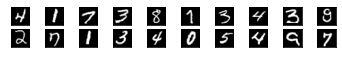

In [237]:
#같은 행의 이미지가 같은 군집
viz_img(y_pred)

In [238]:
#DBSCAN 알고리즘
dunn_index_list = []
silhouette_score_list = []

for eps in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
    from sklearn.metrics import silhouette_score
    model = DBSCAN(min_samples=10, eps=eps,metric='cosine')
        
    model.fit(encoded_imgs_flatten)
    y_pred = model.labels_
    
    Indicator_1, Indicator_2, Dunn_Index = dunn_index(y_pred)
    dunn_index_list.append(Dunn_Index)

    silhouette_score = silhouette_score(encoded_imgs_flatten, y_pred)
    silhouette_score_list.append(silhouette_score)

In [239]:
dunn_index_list

[0.17652396806801565,
 0.32954277236855223,
 0.24892249564189334,
 0.18149704180012363,
 0.17925299674659134,
 0.15756995182272573]

In [240]:
silhouette_score_list

[0.017608345, 0.12339122, -0.07446899, -0.07475157, 0.0322522, 0.0171497]

In [241]:
model = DBSCAN(min_samples=10, eps=0.15,metric='cosine')
model.fit(encoded_imgs_flatten)
y_pred = model.labels_

In [242]:
set(y_pred)

{-1, 0, 1, 2, 3}

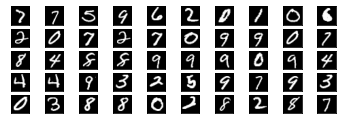

In [243]:
#같은 행의 이미지가 같은 군집    
viz_img(y_pred)

### Weakness of K-Means and DBSCAN
- K-Means와 DBSCAN 알고리즘은 고차원 데이터에 대해 좋지 않은 결과를 보임
- 고차원의 데이터의 경우 최적의 군집의 크기나 밀도가 다를 확률이 높음
- Spectral Clustering은 고차원의 데이터를 저차원에 보낸 후(PCA 적용) 군집을 하므로 이런 고차원 데이터에 좋은 성능을 보임  

![image.png](https://ifh.cc/g/qfcCKO.png)

![image.png](https://ifh.cc/g/hz1jQR.jpg)

In [244]:
from sklearn.cluster import SpectralClustering

In [245]:
model = SpectralClustering(n_clusters=10, random_state=0)
model.fit(encoded_imgs_flatten) ##encoded_img 128차원의 latent vector 넣어서 클러스터링함
y_pred_sc = model.labels_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_k_means.py:291: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  est = KMeans(


In [246]:
Indicator_1, Indicator_2, Dunn_Index_kmeans = dunn_index(y_pred_sc)
print("SC inicator 1:",Indicator_1)
print("SC inicator 2:",Indicator_2)
print("SC Dunn Index:",Dunn_Index_kmeans)

SC inicator 1: 23.829365610099174
SC inicator 2: 32.924068415153876
SC Dunn Index: 0.7237673458098907


In [247]:
from sklearn.metrics import silhouette_score
silhouette_score_sc = silhouette_score(encoded_imgs_flatten, y_pred_sc)
print("SC Silhouette Score:",silhouette_score_sc)

SC Silhouette Score: 0.40837207


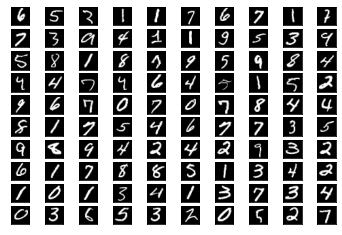

In [248]:
viz_img(y_pred_kmeans)